In [28]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping

from tensorflow.keras.models import load_model


import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#declare sampling rate
sampling_rate = 16000
#get the audio path of all the audios
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/test/librosa_loaded/'

In [65]:
#Read the data and get the shapes of the dataframe
bird_test_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/Inference/test.csv')

#lets only keep audio files > 8 sec
bird_test_df = bird_test_df[bird_test_df['duration_secs'] >= 8]
print(bird_test_df.shape)

bird_test_df.head(2)

(381, 8)


,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent
0,eaywag1,eaywag1/XC131436.ogg,14.027755,call,eaywag1/XC131436.npy,good,FR,EUROPE
1,eaywag1,eaywag1/XC132637.ogg,40.359229,call,eaywag1/XC132637.npy,good,PL,EUROPE


In [66]:
#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [67]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 8.0,
      hop_size_s: float = 4.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=False)
    return framed_audio

In [68]:
def extract_mfcc_and_spectral_centroid_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20, n_chroma=12):
    mfcc_frames = []
    spectral_centroid_frames = []
    target_label = []

    for frame in framed_audio:
        frame = np.array(frame)

        # Extract MFCC from the main audio frame
        mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)
        transposed_mfcc = mfcc.T

        # Extract spectral centroid from the main audio frame
        spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sample_rate)
        transposed_spectral_centroid = spectral_centroid.T

        # Append the features to the respective lists
        mfcc_frames.append(transposed_mfcc)
        spectral_centroid_frames.append(transposed_spectral_centroid)
        target_label.append(class_label)

    # Combine MFCC and spectral centroid features along the time axis
    combined_frames = [np.hstack((mfcc, spectral_centroid)) for mfcc, spectral_centroid in zip(mfcc_frames, spectral_centroid_frames)]
    combined_frames = np.array(combined_frames)

    # Convert the lists to numpy arrays
    target_label = np.array(target_label)

    return combined_frames, target_label

In [75]:
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]

        #For audios with duration >= 8 seconds, proceed as before
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 8-second segments

        # Extract MFCC and spectral centroid features for each frame
        mfcc_frames, target_label = extract_mfcc_and_spectral_centroid_from_frames(framed_audio, class_label, sample_rate=sampling_rate)

        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [76]:
#encode the target variable
def encode_labels(y_test):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_test = to_categorical(le.fit_transform(y_test))
    return encoded_y_test

In [77]:
#scale data
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [78]:
# Extract the mfcc embeddings from the model
test_embeddings, labels = extract_final_features_from_dataframe(bird_test_df)

In [79]:
test_embeddings[:1]

[array([[-4.29811218e+02,  7.39043579e+01,  2.04809151e+01, ...,
         -2.00037885e+00, -2.83571768e+00,  1.79302833e+03],
        [-3.33945526e+02,  6.28633537e+01,  1.32109985e+01, ...,
         -6.14421368e+00,  2.58127546e+00,  1.87258703e+03],
        [-3.07318878e+02,  5.67243958e+01,  6.50288725e+00, ...,
         -6.89109993e+00,  7.98868275e+00,  1.81649683e+03],
        ...,
        [-2.64539886e+02, -9.29640579e+00,  3.17652206e+01, ...,
         -2.46828705e-01,  3.30452800e+00,  3.83695127e+03],
        [-2.42663300e+02, -3.10020809e+01,  5.38850327e+01, ...,
         -4.86471033e+00,  1.04954205e+01,  4.59259426e+03],
        [-2.62114014e+02, -3.72153473e+01,  5.88273926e+01, ...,
         -8.17569256e+00,  1.50389023e+01,  4.42755553e+03]])]

In [80]:
#verify the shapes
x_test = np.array(test_embeddings)
y_test = np.array(labels)
print(x_test.shape)
print(y_test.shape)

(3405, 251, 21)
(3405,)


In [81]:
#call the function to encode y
x_test_scaled = scale_data(x_test)
y_test_encoded = encode_labels(y_test)
print(x_test_scaled.shape)
print(y_test_encoded.shape)

(3405, 251, 21)
(3405, 3)


In [82]:
# Load the trained model
model = load_model('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/RNN/1b.rnngru.model.h5')

In [87]:
test_predictions = model.predict(x_test_scaled)

# Get the class labels (predicted classes) by finding the index of the highest probability for each sample
test_predicted_labels = np.argmax(test_predictions, axis=-1)

# Print the predicted class labels for each sample in the test set
print(test_predicted_labels)

107/107 [==============================] - 28s 258ms/step
[2 2 2 ... 0 0 0]


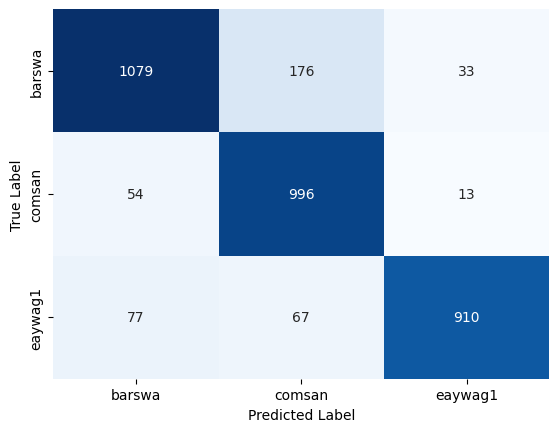

              precision    recall  f1-score   support

           0      0.892     0.838     0.864      1288
           1      0.804     0.937     0.865      1063
           2      0.952     0.863     0.905      1054

    accuracy                          0.877      3405
   macro avg      0.882     0.879     0.878      3405
weighted avg      0.883     0.877     0.877      3405



In [90]:
#plot the confusion matrix on the test dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_test_1d = np.argmax(y_test_encoded, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test_1d, test_predicted_labels)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_test_1d, test_predicted_labels, digits=3, zero_division='warn'))